In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import duckdb
import seaborn as sns
font_scale = 7
sns.set_theme(style='ticks', font_scale=font_scale, palette=sns.color_palette('Set2'),)
import sqlalchemy as sa
import polars as pl
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from conf import conf
from dafm import plots

In [3]:
duckdb.sql("""
attach '../runs.sqlite';
use runs;
""")

In [4]:
engine = conf.get_engine()
session = conf.sa.orm.Session(engine)
session.begin()

# Run queries

### Datasets

In [5]:
dataset_cols = ''.join(map(str.strip, """
    id,
    dataset_name,
    dataset_name_latex_short,
    state_dimension,
    state_dimension_latex,
    time_step_count,
    time_step_count_drop_first,
    observe_every_n_time_steps,
""".splitlines()))

In [6]:
dataset_rows = duckdb.sql(f"""
    select {dataset_cols} from paper_kuramoto_sivashinsky_classical_comparison
    union
    select {dataset_cols} from paper_navier_stokes_classical_comparison
""")
dataset_multiple = 6
assert len(dataset_rows) == dataset_multiple

### Models

In [7]:
model_cols = ''.join(map(str.strip, """
    id,
    model_name,
    hyperparameter1,
    hyperparameter1_name,
    hyperparameter2,
    hyperparameter2_name,
""".splitlines()))

In [8]:
sampling_time_step_counts = duckdb.sql("select 100")
topk_hyperparameters = duckdb.sql("""
    select
        *
    from read_csv('../sweeps/topk_hyperparameters_classical_comparison.csv')
    where true
    and k = 1
    and tie_breaker = 1
    and (
        sampling_time_step_count in (select * from sampling_time_step_counts)
        or
        sampling_time_step_count is null
    )
""")

In [9]:
duckdb.sql("""
select dataset_name, model_name, hyperparameter1, hyperparameter2 from topk_hyperparameters
where model_name in ('BPF', 'EnKF-PO', 'iEnKF-PO', 'ESRF', 'LETKF')
""")

┌─────────────────────┬────────────┬─────────────────┬─────────────────┐
│    dataset_name     │ model_name │ hyperparameter1 │ hyperparameter2 │
│       varchar       │  varchar   │     double      │     double      │
├─────────────────────┼────────────┼─────────────────┼─────────────────┤
│ KuramotoSivashinsky │ BPF        │             1.6 │            NULL │
│ KuramotoSivashinsky │ ESRF       │             1.4 │             7.0 │
│ KuramotoSivashinsky │ EnKF-PO    │             1.0 │             8.0 │
│ KuramotoSivashinsky │ LETKF      │             1.0 │             8.0 │
│ KuramotoSivashinsky │ iEnKF-PO   │             1.8 │            NULL │
│ NavierStokes        │ BPF        │             1.6 │            NULL │
│ NavierStokes        │ ESRF       │             1.8 │             5.0 │
│ NavierStokes        │ EnKF-PO    │             1.1 │             8.0 │
│ NavierStokes        │ LETKF      │             1.0 │             1.0 │
│ NavierStokes        │ iEnKF-PO   │             1.

In [10]:
model_rows = duckdb.sql(rf"""
    select {model_cols} sampling_time_step_count from ensf
    union
    select {model_cols} sampling_time_step_count from enff_ot
    union
    select {model_cols} sampling_time_step_count from enff_f2p
    union
    select {model_cols} null as sampling_time_step_count from bpf
    union
    select {model_cols} null as sampling_time_step_count from enkf_po
    union
    select {model_cols} null as sampling_time_step_count from ienkf_po
    union
    select {model_cols} null as sampling_time_step_count from esrf
    union
    select {model_cols} null as sampling_time_step_count from letkf
""")
model_multiple = 8
assert duckdb.sql('select count(distinct model_name) from model_rows').fetchall()[0][0] == model_multiple

### General

In [11]:
rows = duckdb.sql("""
    select alt_id, rng_seed, dataset_rows.*, model_rows.*
    from Conf
    join dataset_rows on Conf.Dataset = dataset_rows.id
    join model_rows on Conf.Model = model_rows.id
    join topk_hyperparameters on (
        dataset_rows.dataset_name = topk_hyperparameters.dataset_name
        and
        model_rows.model_name = topk_hyperparameters.model_name
        and (
            model_rows.hyperparameter2 is null
            and
            topk_hyperparameters.hyperparameter2 is null
            and
            model_rows.hyperparameter1 = topk_hyperparameters.hyperparameter1
            or
            (model_rows.hyperparameter1, model_rows.hyperparameter2) == (topk_hyperparameters.hyperparameter1, topk_hyperparameters.hyperparameter2)
        )
    )
    where true
    and rng_seed in (select * from rng_seed_test)
    and (
        model_rows.sampling_time_step_count is null
        or
        model_rows.sampling_time_step_count in (select * from sampling_time_step_counts)
    )
""")
rng_seed_multiple = duckdb.sql("select count(*) from rng_seed_test").fetchall()[0][0]
multiple = (
    dataset_multiple
    * rng_seed_multiple
    * model_multiple
    # - (dataset_multiple // 2 * rng_seed_multiple)  # BPF hyperparameter tuning fails for NavierStokes
)
assert len(rows) == multiple, f'{len(rows) = } != {multiple}'

In [12]:
duckdb.sql("""
    select
        dataset_name,
        model_name,
        count(*) as num_rows,
    from rows
    group by
        dataset_name,
        model_name,
    order by num_rows desc, dataset_name, model_name
""")

┌─────────────────────┬────────────┬──────────┐
│    dataset_name     │ model_name │ num_rows │
│       varchar       │  varchar   │  int64   │
├─────────────────────┼────────────┼──────────┤
│ KuramotoSivashinsky │ BPF        │       15 │
│ KuramotoSivashinsky │ ESRF       │       15 │
│ KuramotoSivashinsky │ EnFF-F2P   │       15 │
│ KuramotoSivashinsky │ EnFF-OT    │       15 │
│ KuramotoSivashinsky │ EnKF-PO    │       15 │
│ KuramotoSivashinsky │ EnSF       │       15 │
│ KuramotoSivashinsky │ LETKF      │       15 │
│ KuramotoSivashinsky │ iEnKF-PO   │       15 │
│ NavierStokes        │ BPF        │       15 │
│ NavierStokes        │ ESRF       │       15 │
│ NavierStokes        │ EnFF-F2P   │       15 │
│ NavierStokes        │ EnFF-OT    │       15 │
│ NavierStokes        │ EnKF-PO    │       15 │
│ NavierStokes        │ EnSF       │       15 │
│ NavierStokes        │ LETKF      │       15 │
│ NavierStokes        │ iEnKF-PO   │       15 │
├─────────────────────┴────────────┴────

In [13]:
logged_metrics_file_paths = plots.get_logged_metrics_file_paths(rows)
duckdb.sql("""
set variable dataset_metrics_filepaths = (
    select list(path) from logged_metrics_file_paths where exists
)
""")

##### RMSE and CRPS    

In [14]:
observation_steps_back = 50
logged_metrics = duckdb.sql(f"""
    select rows.*, logs.*,
    from (
        select split(filename, '/')[-2] as alt_id, step, time_s, crps, rmse,
        from read_csv(getvariable(dataset_metrics_filepaths), filename=true, union_by_name=true)
    ) as logs
    join rows on rows.alt_id = logs.alt_id
    where true
    and (logs.step - time_step_count_drop_first - 1) % observe_every_n_time_steps == 0 -- include only analysis time steps
    and step > time_step_count - observe_every_n_time_steps * {observation_steps_back}
""")
logged_metrics.show(max_width=125)

┌──────────┬───────────┬───────┬─────────────────────┬───┬──────────────────────┬────────────────────┬─────────────────────┐
│  alt_id  │ rng_seed  │  id   │    dataset_name     │ … │        time_s        │        crps        │        rmse         │
│ varchar  │   int64   │ int64 │       varchar       │   │        double        │       double       │       double        │
├──────────┼───────────┼───────┼─────────────────────┼───┼──────────────────────┼────────────────────┼─────────────────────┤
│ evsgw39m │  19704671 │    50 │ KuramotoSivashinsky │ … │  0.0030561820000016… │  46.21995912494359 │   1.459225330372237 │
│ 1m4we0x7 │  19704671 │    34 │ KuramotoSivashinsky │ … │ 0.003070713999999697 │  33.47359382925267 │  1.5009831437385153 │
│ qy7h9193 │ 715319214 │    50 │ KuramotoSivashinsky │ … │  0.0035706239999981… │ 41.837189969008875 │  1.3230105465622204 │
│ n7seh869 │ 715319214 │    34 │ KuramotoSivashinsky │ … │  0.0030269579999995… │  39.29485827679733 │  1.7585130527933952 │


##### Time (seconds)

In [ ]:
observation_steps_back = None
logged_metrics = duckdb.sql(f"""
    select rows.*, logs.*,
    from (
        select split(filename, '/')[-2] as alt_id, step, time_s, crps, rmse,
        from read_csv(getvariable(dataset_metrics_filepaths), filename=true, union_by_name=true)
    ) as logs
    join rows on rows.alt_id = logs.alt_id
    where true
    and (logs.step - time_step_count_drop_first - 1) % observe_every_n_time_steps == 0 -- include only analysis time steps
""")
logged_metrics.show(max_width=125)

In [15]:
required_observation_step_count = duckdb.sql(f"""
    select
        dataset_name,
        state_dimension,
        max(observation_step_count) as required_observation_step_count,
    from (
        select
            dataset_name,
            state_dimension,
            count(*) as observation_step_count,
        from logged_metrics
        group by alt_id, dataset_name, state_dimension
    )
    group by dataset_name, state_dimension
    order by dataset_name, state_dimension
""")
required_observation_step_count

┌─────────────────────┬─────────────────┬─────────────────────────────────┐
│    dataset_name     │ state_dimension │ required_observation_step_count │
│       varchar       │      int64      │              int64              │
├─────────────────────┼─────────────────┼─────────────────────────────────┤
│ KuramotoSivashinsky │             256 │                              50 │
│ KuramotoSivashinsky │             512 │                              50 │
│ KuramotoSivashinsky │            1024 │                              50 │
│ NavierStokes        │             300 │                              50 │
│ NavierStokes        │           12288 │                              50 │
│ NavierStokes        │          196608 │                              50 │
└─────────────────────┴─────────────────┴─────────────────────────────────┘

In [16]:
failed_before_finish_cols = """
    alt_id,
    dataset_name,
    state_dimension,
    model_name,
"""
failed_before_finish = duckdb.sql(f"""
    select
        observation_steps_back.*,
    from (
        select
            {failed_before_finish_cols}
            count(*) as observation_step_count,
        from logged_metrics
        group by {failed_before_finish_cols}
    ) as observation_steps_back
    join required_observation_step_count
    on observation_steps_back.dataset_name = required_observation_step_count.dataset_name
    and observation_steps_back.observation_step_count < required_observation_step_count.required_observation_step_count
    order by observation_steps_back.dataset_name, observation_steps_back.state_dimension, model_name desc, observation_step_count
""")
failed_before_finish

┌──────────┬──────────────┬─────────────────┬────────────┬────────────────────────┐
│  alt_id  │ dataset_name │ state_dimension │ model_name │ observation_step_count │
│ varchar  │   varchar    │      int64      │  varchar   │         int64          │
├──────────┼──────────────┼─────────────────┼────────────┼────────────────────────┤
│ ff90bdbe │ NavierStokes │             300 │ iEnKF-PO   │                     20 │
│ ff90bdbe │ NavierStokes │             300 │ iEnKF-PO   │                     20 │
│ ff90bdbe │ NavierStokes │             300 │ iEnKF-PO   │                     20 │
│ 00ndd1fs │ NavierStokes │             300 │ LETKF      │                     10 │
│ 00ndd1fs │ NavierStokes │             300 │ LETKF      │                     10 │
│ 00ndd1fs │ NavierStokes │             300 │ LETKF      │                     10 │
│ rc41co9o │ NavierStokes │             300 │ LETKF      │                     20 │
│ rc41co9o │ NavierStokes │             300 │ LETKF      │                  

In [17]:
logged_metrics = duckdb.sql("""
    select *
    from logged_metrics
    where alt_id not in (select alt_id from failed_before_finish)
""")

In [18]:
duckdb.sql(r"""
    select
        dataset_name,
        if(dataset_name = 'NavierStokes', format('${0} \times {0}$', cast(sqrt(state_dimension / 3) as integer)), format('{}', state_dimension)) as state_dimension,
        model_name,
        count(*) as 'Num. runs failed',
    from rows
    where
        alt_id not in (
            select alt_id from logged_metrics
        )
    group by dataset_name, model_name, state_dimension
    order by dataset_name, state_dimension, model_name desc
""")

┌─────────────────────┬──────────────────┬────────────┬──────────────────┐
│    dataset_name     │ state_dimension  │ model_name │ Num. runs failed │
│       varchar       │     varchar      │  varchar   │      int64       │
├─────────────────────┼──────────────────┼────────────┼──────────────────┤
│ KuramotoSivashinsky │ 256              │ iEnKF-PO   │                2 │
│ KuramotoSivashinsky │ 256              │ LETKF      │                2 │
│ KuramotoSivashinsky │ 256              │ EnSF       │                2 │
│ KuramotoSivashinsky │ 256              │ EnKF-PO    │                2 │
│ KuramotoSivashinsky │ 256              │ EnFF-OT    │                2 │
│ KuramotoSivashinsky │ 256              │ EnFF-F2P   │                2 │
│ KuramotoSivashinsky │ 256              │ ESRF       │                3 │
│ NavierStokes        │ $10 \times 10$   │ iEnKF-PO   │                4 │
│ NavierStokes        │ $10 \times 10$   │ LETKF      │                3 │
│ NavierStokes        │ $

In [19]:
group_by = """
    alt_id,
    rng_seed,
    dataset_name,
    dataset_name_latex_short,
    state_dimension,
    state_dimension_latex,
    model_name,
    sampling_time_step_count,
    hyperparameter1,
    hyperparameter1_name,
    hyperparameter2,
    hyperparameter2_name,
"""
logged_metrics_means = duckdb.sql(f"""
    select
        {group_by}
        mean(time_s) as time_s_mean,
        mean(rmse) as rmse,
        mean(crps) as crps,
    from logged_metrics
    group by
        {group_by}
""")
logged_metrics_means.show(max_width=125)

┌──────────┬───────────┬─────────────────────┬───┬──────────────────────┬──────────────────────┬─────────────────────┐
│  alt_id  │ rng_seed  │    dataset_name     │ … │     time_s_mean      │         rmse         │        crps         │
│ varchar  │   int64   │       varchar       │   │        double        │        double        │       double        │
├──────────┼───────────┼─────────────────────┼───┼──────────────────────┼──────────────────────┼─────────────────────┤
│ d4qmakrf │ 462133975 │ KuramotoSivashinsky │ … │  0.06463353371999972 │   1.6552422829639895 │  52.510694146999725 │
│ lzei7xa9 │ 979497033 │ KuramotoSivashinsky │ … │   0.2312947197800014 │  0.07667088358209216 │   2.022480548338697 │
│ n6uh0bey │ 462133975 │ NavierStokes        │ … │   0.5347790639800013 │   0.1634632655978203 │  17.827037162780762 │
│ scwpaqvk │ 462133975 │ NavierStokes        │ … │   6.3937180903999975 │  0.01773574009537697 │   7.582360906600952 │
│ mdxwv9cm │ 979497033 │ KuramotoSivashinsky │ …

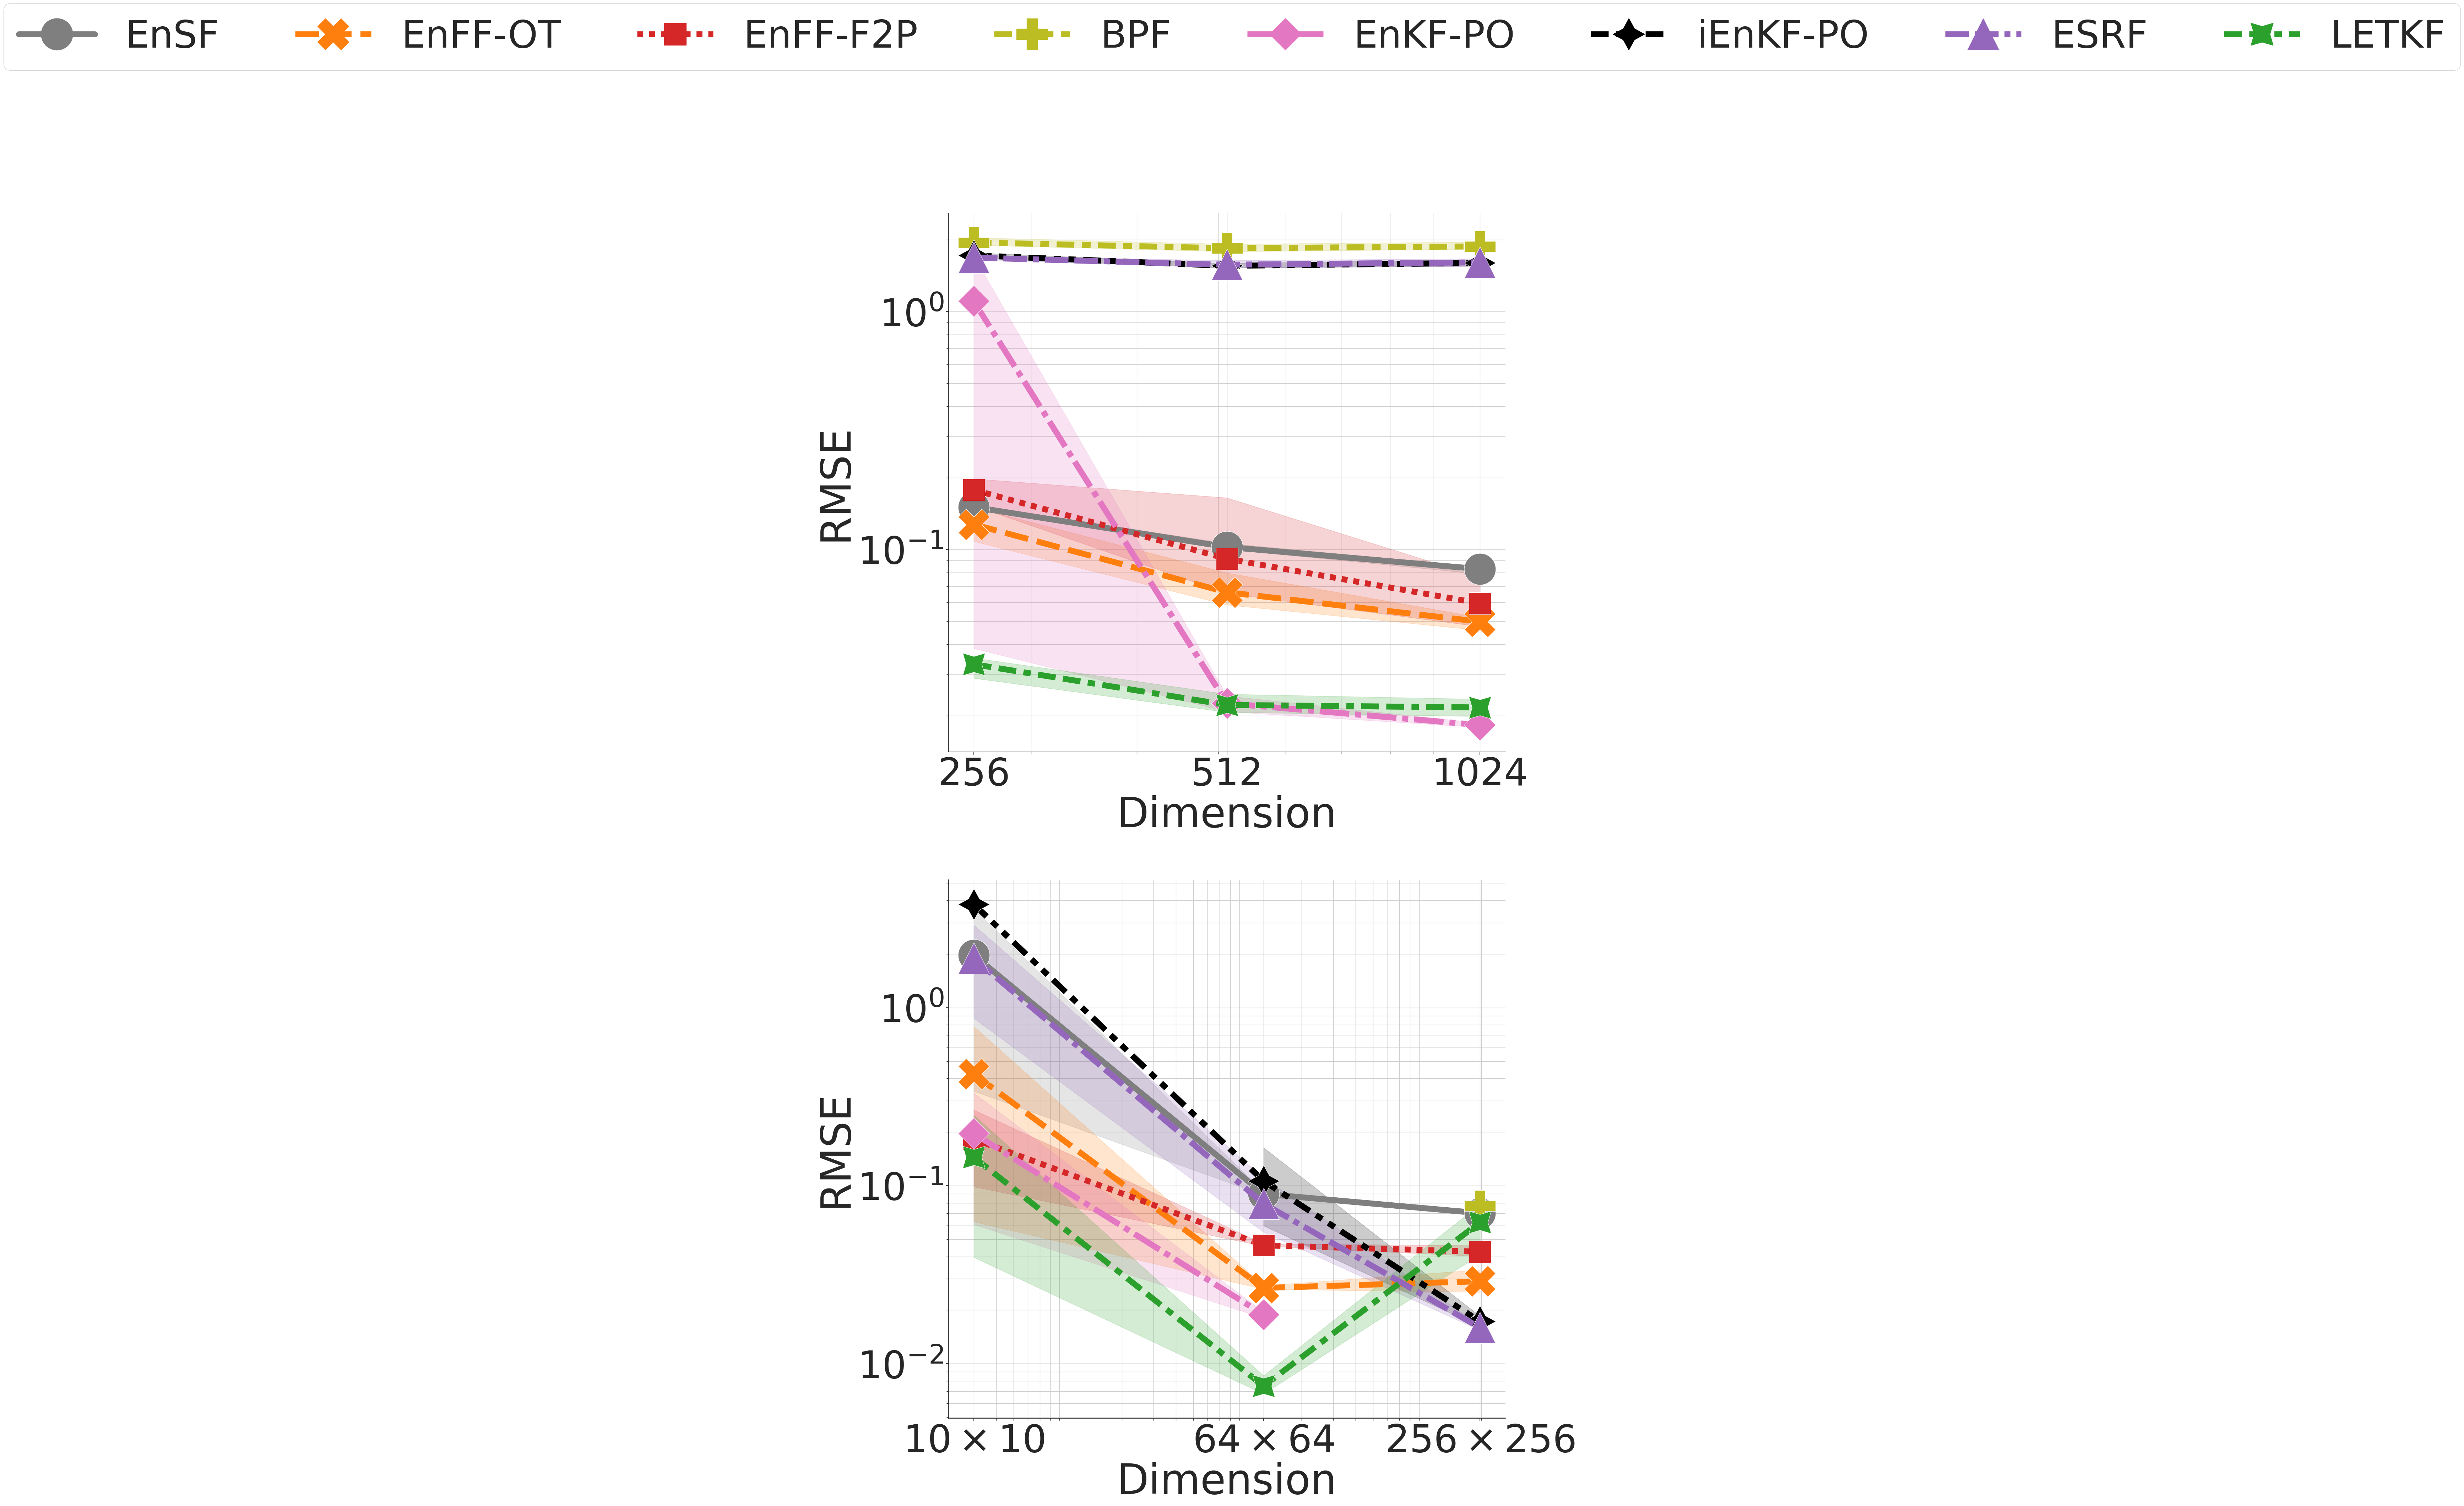

In [20]:
plot_data = logged_metrics_means.pl()
hue_order = sorted(plot_data['model_name'].unique(), key=plots.MODEL_ORDER.get)
y = 'rmse'
plot_metric = (
    sns.relplot(
        kind='line',
        estimator='mean',
        errorbar=('pi', 100),
        data=plot_data,
        x='state_dimension',
        y=y,
        row='dataset_name',
        hue='model_name',
        hue_order=hue_order,
        style='model_name',
        style_order=hue_order,
        palette=plots.MODEL_PALETTE,
        markers=True,
        markersize=64,
        linewidth=12,
        height=20,
        aspect=1.1,
        facet_kws=dict(
            sharex=False,
            sharey=False,
        ),
    )
    .set(
        xscale='log',
        yscale='log',
        title='',
        xlabel='Dimension',
        ylabel=y.upper(),
        # ylabel='Time (s)',
    )
)
sns.move_legend(
    plot_metric,
    loc='upper center',
    ncol=len(hue_order),
    title='',
    bbox_to_anchor=(.455, 1.10),
    frameon=True,
    fancybox=True,
)
for (row, col, hue), _ in plot_metric.facet_data():
    ax = plot_metric.axes[row, col]
    ax.grid()
    ax.grid(which='minor')
    dataset_name = plot_metric.row_names[row]
    xticks, xticklabels = (
        plot_data.filter(dataset_name=dataset_name)
        [['state_dimension', 'state_dimension_latex']]
        .unique()
        .sort('state_dimension')
    )
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    from matplotlib.ticker import FuncFormatter
    ax.xaxis.set_minor_formatter(FuncFormatter(lambda x, pos: ''))
    # ax.minorticks_off()

In [21]:
plots.save_all_subfigures(plot_metric, y.upper())